# Chap07 - 앙상블 학습과 랜덤 포레스트

**앙상블(ensemble)**이란 프랑스어이며 뜻은 *조화* 또는 *통일*을 의미한다. 

머신러닝에서 여러개의 모델을 학습시켜 그 모델들의 예측결과들을 이용해 하나의 모델보다 더 나은 값을 예측하는 방법을 말한다. 이러한 방법을 **앙상블 학습**(ensemble learning) 또는 **앙상블 방법**(ensemble method)이라고 한다.

앙상블 학습의 대표적인 예로는 **랜덤 포레스트**(Random Forest)가 있다. 랜덤포레스트는 여러개의 의사결정나무(decision tree)들을 생성한 다음, 각 개별 트리의 예측값들 중에서 가장 많은 선택을 받은 클래스(또는 label)로 예측하는 알고리즘이다.

이번 장에서는 랜덤포레스트 뿐만아니라 **배깅, 부스팅, 스태킹** 등 앙상블 학습에 대해 알아 보도록 하자.

## SetUp

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

## 7.1 투표 기반 분류기(Voting Classifier)

투표 기반 분류기는 아래의 그림에서 볼 수 있듯이, 학습 단계에서 여러개의 머신러닝 알고리즘 모델을 학습시킨 후 이러한 모델들을 이용해 새로운 데이터에 대해 각 모델의 예측값을 가지고 **다수결 투표**를 통해 최종 클래스를 예측하는 방법을 말한다. 이러한 분류기를 **직접 투표**(hard voting) 분류기라고 한다.

![](./images/ensemble02.png)

이러한 다수결 투표 분류기가 앙상블에 포함된 개별 분류기(위의 그림에서는 LR, RF, SVM, ...) 중 가장 성능이 좋은 분류기 보다 정확도가 더 높을 경우가 많다고 한다. 

### 투표 분류기가 더 좋은 이유

예를 들어 앞면이 나올 확률이 51%이고, 뒷면이 나올 확률이 49%인 동전 던지기를 한다고 가정하자. 이러한 동전을 1,000번 던지면 약 510번은 앞면, 490번은 뒷면이 나오게 될것이다. 따라서 더 많은 횟수로 앞면이 나온다는 것을 알 수 있다. 이를 수학적으로 계산해보면 1,000번을 던진 후 앞면이 더 많이 나올 확률은 75%에 가까운 것을 알 수 있다. 동전 던지기는 이항분포이므로 다음과 같이 나타낼 수 있다.

$$
\binom{n}{k} p^{k}\left( 1-p \right)^{n-k}
$$

위의 식을 이용해 0~499 까지의 누적 분포 함수(CDF, Cumulative Distribution Function)를 이용해 누적 확률을 계산한 뒤, 전체 확률 1에서 빼주면 75%를 구할 수 있다. 이를 [`SciPy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)를 이용해 `1-scipy.stats.binom.cdf(499, 1000, 0.51)` 구할 수 있다. 또한, 동전을 10,000번 던진다면 앞면이 더 많이 나올 확률이 97%(`1 - scipy.stats.binom.cdf(4999, 10000, 0.51)`) 이상으로 올라간다. 

이와 비슷하게 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축할 경우 정확도는 75%로 기대할 수 있다. 그러나 이러한 가정은 모든 분류기가 독립적이어야 하고, 오차에 대해 상관관계가 없어야 한다. 

따라서, 앙상블 기법에서 독립적인 모델을 만들어 주기 위해서는 다른 머신러닝 알고리즘으로 학습시키는 것이 좋다. 그 이유는 모델 별로 다른 종류의 오차를 가지므로 상관관계가 작어지기 때문이다.

In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

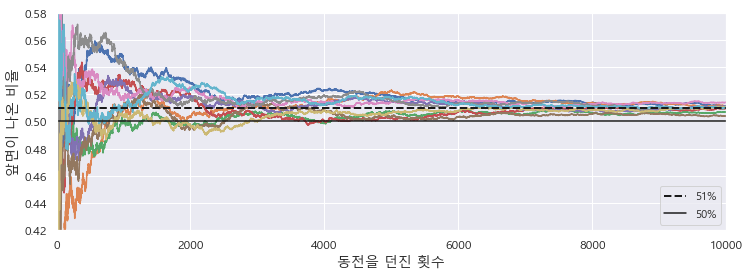

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

### moons 데이터셋에 앙상블 학습 적용하기

위에서 살펴본 투표 분류기를 Scikit-Learn의 [`VotingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)를 이용해 예제 데이터셋인 `moons`데이터 셋에 적용해보자. `moons` 데이터셋은 Scikit-Learn에서 제공하는 반달 모양의 데이터셋이다.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Hard voting

`VotingClassifier`에서 `voting='hard'` 인 경우 각 분류기의 예측값(레이블)을 가지고 다수결 투표를 통해 최종 앙상블 예측이 이루어진다.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [8]:
# LabelEncoder 버그로 인해 생기는 DeprecationWarning 막기
# https://github.com/scikit-learn/scikit-learn/pull/9816
# https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


#### Soft voting

`VotingClassifier`에서 `voting='soft'` 인 경우 각 분류기의 예측값(레이블)의 확률을 가지고 평균을 구한 뒤, 평균이 가장 높은 클래스로 최종 앙상블 예측이 이루어진다. 이러한 방법을 **간접 투표**(soft voting)이라 한다.

In [10]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## 7.2 배깅과 페이스팅 (Bagging and Pasting)

'7.1 - 투표기반 분류기'에서는 여러개의 머신러닝 알고리즘을 이용해 분류기를 만들어 앙상블 학습을 했다. 이번에 알아볼 또 다른 방법으로는 하나의 알고리즘을 사용하지만 학습 데이터셋을 랜덤하게 추출하여 모델(분류기)을 각각 다르게 학습시키는 방법이다. 

이렇게, 학습 데이터셋에서 랜덤하게 추출할 때, 중복을 허용하는 방식을 **배깅**(bagging)이라고 한다. 배깅(bagging)은 **bootstrap aggregating**의 줄임말이며 통계학에서는 중복을 허용한 리샘플링(resampling)을 **부트스트래핑**(bootstraping)이라고 한다. 이와 반대로 중복을 허용하지 않는 샘플링 방식을 **페이스팅**(pasting)이라고 한다.

![](./images/bagging.png)

위의 그림에서 각 모델이 학습된 후에 새로운 데이터에 대해서는 '7.1 - 투표기반 분류기'와 동일하게 분류(classification)일 때는 **최빈값(mode)** 즉, 가장 많은 예측 클래스로 앙상블이 예측하며, 회귀(regression)일 경우에는 각 분류기의 예측값의 평균을 계산하여 평균값을 예측값으로 한다.

각 모델은 전체 학습 데이터셋으로 학습시킨 것보다 편향되어 있지만, 앙상블을 통해 편향(bias)과 분산(variance)이 감소한다. 일반적으로 앙상블 학습은 전체 학습 데이터셋을 이용해 하나의 모델을 학습시킬 때와 비교해서 편향은 비슷하지만 분산은 줄어든다고 한다. 

### 7.2.1 사이킷런의 배깅과 페이스팅

Scikit-Learn은 배깅과 페이스팅을 간편하게 사용할 수 있도록 분류일 경우에는 [`BaggingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)를 회귀일 경우 [`BaggingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)를 제공한다. 

아래의 예제는 '7.1 - 투표기반 분류기'에서 다룬 `moons` 데이터셋을 `BaggingClassifier`를 이용해 500개의 의사결정나무(decision tree)모델을 만들어 배깅을 적용한 앙상블 학습을 한 예제이다.

#### `moons` 데이터셋 로드하기

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 단 하나의 Decision Tree를 사용할 경우

먼저 배깅을 이용한 앙상블 학습이 얼마나 더 성능이 좋은지 비교하기 위해, 단 하나의 의사결정나무 모델을 이용해 `moons` 데이터셋에 적용해 보자.

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


#### Bagging을 이용한 앙상블 학습

이번에는 `BaggingClassifier`를 이용해 500개의 의사결정나무 모델을 만들어 보자. `BaggingClassifier`는 사용하는 알고리즘 모델(분류기)가 각 예측 클래스의 확률을 추정할 수 있으면, 직접 투표(hard voting)대신 간접 투표(soft voting) 방식을 사용한다.

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


위에서 확인할 수 있듯이 배깅을 이용한 방법이 정확도가 5%나 더 좋게 나온것을 확인할 수 있다. 아래의 그림은 하나의 의사결정나무에 대한 결정 경계(decision boundary)와 배깅을 이용한 앙상블 트리에 대한 결정 경계를 비교한 그래프이다. 그래프에서도 확인할 수 있듯이 앙상블 학습이 일반화(generalization)이 더 잘 된것을 알 수 있다.

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

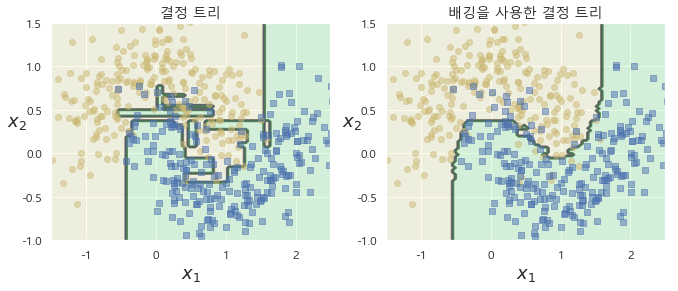

In [16]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

### 7.2.2 OOB(Out-of-Bag) 평가

배깅은 중복을 허용하는 리샘플링(resampling) 즉, 부트스트래핑(bootstraping) 방식이기 때문에 전체 학습 데이터셋에서 어떠한 데이터 샘플은 여러번 샘플링 되고, 또 어떠한 샘플은 전혀 샘플링 되지 않을 수가 있다. 평균적으로 학습 단계에서 전체 학습 데이터셋 중 63% 정도만 샘플링 되며(자세한 내용은 [여기](https://tensorflow.blog/%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EC%97%90%EC%84%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EB%88%84%EB%9D%BD%EB%90%A0-%ED%99%95%EB%A5%A0/) 참고), 샘플링 되지 않은 나머지 37% 데이터 샘플들을 **oob(out-of-bag) 샘플**이라고 한다.

앙상블(배깅) 모델의 학습 단계에서는 oob 샘플이 사용되지 않기 때문에, 이러한 oob 샘플을 검증셋(validation set)이나 교차검증(cross validation)에 사용할 수 있다. 

Scikit-Learn에서는 `BaggingClassifier`의 인자인 `oob_score=True`로 설정하면 학습이 끝난 후 자동으로 oob 평가를 할 수 있다. 

아래의 예제는 7.2.1 에서 `moons` 데이터셋을 `BaggingClassifier`를 적용한 후 oob 평가를 해준 것이다.

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

print('oob score :', bag_clf.oob_score_)

oob score : 0.9013333333333333


아래의 코드와 같이 oob 샘플에 대한 결정 함수(decision function) 값도 확인할 수 있다.

In [18]:
bag_clf.oob_decision_function_[:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.3 Random Patches & Random Subspace

`BaggingClassifier`는 특성(feature) 샘플링 또한 `max_features`와 `bootstrap_features` 두 개의 인자를 통해 제공한다. 위의 두 인자를 이용해 각 모델은 랜덤하게 선택한 특성(feature)으로 학습하게 된다.

이러한 방법은 데이터의 특성이 많은 고차원의 데이터셋을 다룰 때 적절하다. 학습 데이터 셋의 특성 및 샘플링(bootstraping) 사용 유무에 따라 두 종류로 나눌 수 있다.

- **Random Patches method** : 특성 및 데이터 셋 샘플링(bootstraping) 모두 사용하는 방식 
- **Random Subspace method** : 특성만 샘플링하는 방식
    - `bootstrap=False` 이고, `bootstrap_features=True` 그리고 `max_features`는 1.0보다 작은 값

이러한 특성 샘플링은 더 다양한 모델을 만들며 편향은 늘어나지만 분산을 낮출 수 있다.

## 7.4 랜덤 포레스트 (Random Forest)

**랜덤 포레스트**(Random Forest)는 7.2.1의 예제에서 보았듯이 배깅(bagging)을 적용한 의사결정나무(decision tree)의 앙상블이다. 7.2.1의 예제에서는 `BaggingClassifier`에 `DecisionTreeClassifier`를 인자로 넣어 줬었다. Scikit-Learn에서는 랜덤 포레스트를 간편하게 쓸 수 있도록 [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)를 제공 한다.

아래의 예제는 7.2.1의 예제를 `RandomForestClassifier` 를 이용해 모델링하고, 7.2.1의 방식과 비교한 것이다.

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

# BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

# 두 모델의 예측 비교
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

0.976


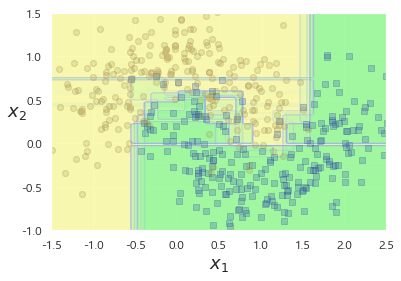

In [18]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 7.4.1 엑스트라 트리 (Extremely Randomized Trees)

랜덤 포레스트는 트리를 생성할 때, 각 노드는 랜덤하게 특성(feature)의 서브셋(자식 노드를)을 만들어 분할한다. 반면 **익스트림 랜덤 트리**(Extremely Randomized Trees) 또는 **엑스트라 트리**(Extra-Trees)는 트리를 더욱 랜덤하게 생성하기 위해 노드를 분할하는 최적의 임계값을 찾는 것이 아니라 후보 특성을 이용해 랜덤하게 분할한 다음 그 중에서 최상의 분할을 선택하는 방법이다. 랜덤 포레스트 처럼 각 노드의 특성마다 최적의 임계값을 찾는것이 아니기 때문에 엑스트라 트리가 훨씬 학습 속도가 빠르다.

Scikit-Learn에서는 [`ExtraTreesClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)을 이용해 엑스트라 트리를 구현할 수 있다. 

아래의 예제는 랜덤포레스트와 엑스트라 트리를 비교한 것이다.

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_clf.fit(X_train, y_train)
y_pred_ext = extra_clf.predict(X_test)

# 두 모델의 예측 비교
print(np.sum(y_pred_rf == y_pred_ext) / len(y_pred_rf))

0.968


### 7.4.2 특성 중요도 (Feature Importance)

랜덤 포레스트의 장점은 특성(feature)의 상대적인 중요도를 측정하기 쉽다는 것이다. Scikit-Learn에서는 어떠한 특성을 사용한 노드가 불순도(impurity)를 얼마나 감소시키는지를 계산하여 각 특성마다 상대적 중요도를 측정한다. 불순도에 대해서는 [**여기**](https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap06-Decision_Tree/Chap06-Decision_Tree.ipynb)를 참고하면 된다.

Scikit-Learn의 `RandomForestClassifier`에서 `feature_importances_` 변수를 통해 해당 특성의 중요도를 확인할 수 있다. 

아래의 예제는 붗꽃(iris) 데이터셋을 `RandomForestClassifier`를 이용해 학습시키고 각 특성의 중요도를 출력하는 예제이다.

In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


#### MNIST 데이터의 각 픽셀 중요도 알아보기

이번에는 MNIST 데이터셋에 랜덤 포레스트 분류기를 학습 시키고, 각 픽셀을 하나의 특성으로 보고 각 픽셀의 중요도를 그래프로 나타내보자.

In [21]:
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [22]:
X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])
y = np.append(train_y, test_y)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [23]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

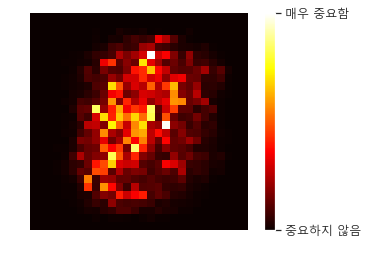

In [24]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요함'])

plt.show()

## 7.5 부스팅 (boosting)

**부스팅**(boosting)은 성능이 약한 학습기(weak learner)를 여러 개 연결하여 강한 학습기(strong learner)를 만드는 앙상블 학습이다. 부스팅 방법의 아이디어는 앞에서 학습된 모델을 보완해나가면서 더나은 모델로 학습시키는 것이다. 부스팅 방법에는 여러 종류가 있는데, 그 중 가장 유명하고 인기 있는 모델은 **아다부스트**(AdaBoost, Adaptive Boosting)와 **그래디언트 부스팅**(Gradient Boosting) 두 가지가 있다.

### 7.5.1 아다부스트 (AdaBoost)

아다부스트(AdaBoost)는 과소적합(underfitted)됐던 학습 데이터 샘플의 가중치를 높이면서 새로 학습된 모델이 학습하기 어려운 데이터에 더 잘 적합되도록 하는 방식이다. 아래의 그림에서 처럼 아다부스트의 단계를 설명하면 다음과 같다.

1. 먼저 전제 학습 데이터셋을 이용해 모델을 만든 후, 잘못 예측(분류)된 샘플의 가중치를 상대적으로 높여준다. 
2. 그 다음 두 번째 모델을 학습 시킬때 이렇게 업데이트된 가중치를 반영하여 모델을 학습 시킨다. 
3. 이와 같은 과정을 반복한다.



![](./images/adaboost.png)

#### moons 데이터셋에 AdaBoost 적용하기

Scikit-Learn에는 AdaBoost를 사용할 수 있도록 [`AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)를 제공한다. 

아래의 예제는 `moons`데이터셋에 `AdaBoostClassifier` 모델을 학습시킨 것이다. 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

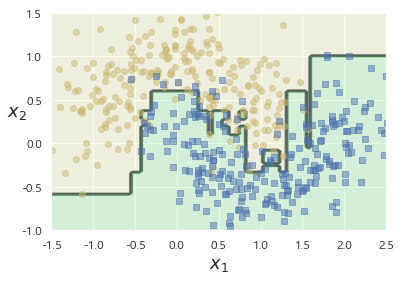

In [28]:
plot_decision_boundary(ada_clf, X, y)

#### AdaBoost 알고리즘

AdaBoost의 논문인 [*A Short Introduction to Boosting*](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)에서 AdaBoost 알고리즘은 다음과 같다.

<img src="./images/adaboost03.png" height="75%" width="75%"/>

위의 알고리즘을 각 단계별로 살펴보자. 

① 먼저 각 데이터의 가중치 $w_i$는 $\frac{1}{m}$으로 초기화한다.

$t = 1, \dots, T$ 까지 반복하는데, 

② 모델이 학습되고, 가중치가 적용된 에러율(weighted error rate)을 계산한다.

$$
\epsilon_t = \frac{\underset{ h_{t}(x_i) \neq y_i }{ \sum_{i=1}^{m}{w_i} } }{\sum_{i=1}^{m}{w_i}}
$$

- $h_{t}(x_i)$는 $i$-번째 데이터에 대한 $t$-번째 모델의 예측값이다.
- 위의 식은 $t$-번째 모델에서 실제값과 예측값이 같지 않은($ h_{t}(x_i) \neq y_i$) 샘플의 가중치($w_i$)의 합에서 전체 가중치의 합으로 나눈 비율을 에러율($\epsilon_t$)라고 정의한 것이다.

③ 각 $t$-번째 모델에 대한 가중치 $\alpha_t$는 다음과 같다.

$$
\alpha_t = \eta \log{\frac{1 - \epsilon_t}{\epsilon_t}}
$$

- $\eta$는 학습률(learning rate)을 의미하며, 논문에서는 학습률은 사용하지 않지만, scikit-learn의 [`AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)에서는 `learning_rate`의 인자가 있으며, 기본값은 `1`이다. 

④ 그런 다음, 아래의 식을 통해 가중치($w_i$)를 업데이트 해준다.

$$
W_{t+1} = \frac{W_t(i) \exp{\left( - \alpha_t y_i h_t \left(x_i \right) \right)}}{Z_t}
$$

- $Z_t$는 정규화 인자이며, $t$-번째 모델에서 모든 데이터의 가중치를 정규화 해준다($\sum_{i=1}^{m}{w_i}$로 나눠준다).

⑤ 학습이 끝난 후 최종 결과는 $T$개의 weak learner를 **weighted linear combination**(가중치 선형결합)을 하여 strong learner $H(x)$를 구하여 값을 예측한다.

$$
H(\mathbf{x}) = \alpha_1 h_1(\mathbf{x}) + \cdots + \alpha_{T} h_{T}(\mathbf{x}) = \sum_{t=1}^{T}{\alpha_t h_t(\mathbf{x})}
$$


#### Scikit-Learn에서 AdaBoost 알고리즘

Scikit-Learn의 `AdaBoostClassifier`에서는 **SAMME**(Stagewise Additive using a Multiclass Exponential loss function)과 **SAMME.R**(R은 Real을 의미)이라는 **Multi-Class AdaBoost**를 사용(default는 `algorithm='SAMME.R'`)한다. SAMME 알고리즘은 위의 AdaBoost 알고리즘과 거의 동일하며, $t$-번째 모델에 대한 가중치를 계산하는 부분인 ③에서의 식이 아래와 같이 다르다.

$$
\alpha_t = \eta \left( \log{\frac{1-\epsilon_t}{\epsilon_t}} + \log{(K-1)} \right)
$$

- $K$는 클래스(레이블)을 의미하며 2일 경우, 즉 이진분류일 경우에는 위의 AdaBoost와 동일한 알고리즘이 된다. 

**SAMME.R**은 각 모델의 예측값이 아닌 soft voting 처럼 예측 클래스의 확률을 이용해, $t$-번째 모델에 대한 가중치(③부분)를 계산하는 알고리즘이다.

$$
\alpha_t = -\eta \frac{K-1}{K} y \log{\hat{y}_t}
$$

- $y$는 예측한 클래스와 실제 클래스가 일치(정답)할 경우에는 $1$, 그렇지 않으면 $-\frac{1}{1-K}$이다.
- $\hat{y}_t$는 $t$-번째 모델이 예측한 클래스의 확률이며 식은 다음과 같다.

$$
\hat{y}(x) = \underset{k}{\text{argmax}} \sum_{t=1}^{T}{(K-1)\left( \log{\hat{y}_t} - \frac{1}{K} \sum_{k=0}^{K}{\hat{y}_t} \right)}
$$

### 7.5.2 그래디언트 부스팅

이번에는 부스팅의 또 다른 인기 알고리즘인 **그래디언트 부스팅**(Gradient Boosting)에 대해 알아보도록 하자. 그래디언트 부스팅은 '7.5.1 - 아다부스트'에서 살펴본 것 처럼 전의 학습된 모델의 오차를 보완하는 방향으로 모델(분류기, 학습기)을 추가해주는 방법은 동일하다. 하지만, **그래디언트 부스팅**은 아다부스트 처럼 학습단계 마다 데이터 샘플의 가중치를 업데이트 해주는 것이 아니라 학습 전단계 모델에서의 **잔여 오차(residual error)**에 대해 새로운 모델을 학습시키는 방법이다. 

![](./images/gbt.png)

#### 예제 데이터에 그래디언트 부스팅 적용하기

아래의 예제는 그래디언트 부스팅을 회귀문제에 적용해 본 예제이다. 예제 데이터의 모양은 아래의 식과 같다.

$$
y = 3X^{2} + 0.05 + \text{noise}
$$

그래디언트 부스팅은 의사결정나무(decision tree) 알고리즘을 이용해 그래디언트 부스팅을 사용하며, 이를 **그래디언트 트리 부스팅** 또는 **그래디언트 트리 부스팅** 또는 **그래디언트 부스티드 회귀 트리(GRBT)**라고 한다. 

먼저 `DecisionTreeRegressor` 그래디언트 부스팅을 단계별로 살펴보자.

In [31]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

처음 학습시킨 모델 `tree_reg1`에 대한 잔여 오차(residual error)를 구한 뒤 이것을 가지고 두번째 `DecisionTreeRegressor`모델을 학습시킨다.

In [33]:
y2 = y - tree_reg1.predict(X)  # residual errors

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

위와 같은 방법으로 두번째 모델에 대한 잔여 오차를 구해 세번째 모델을 학습시킨다.

In [34]:
y3 = y2 - tree_reg2.predict(X)  # residual error

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

이렇게 학습 시킨 그래디언트 부스팅 모델에 새로운 데이터 `X_new = 0.8`에 대해 예측값을 구해보자.

In [35]:
X_new = np.array([[0.8]])  # new data

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print('y_pred :', y_pred)

y_pred : [0.75026781]


위의 과정을 그림으로 나타내면 아래와 같다.

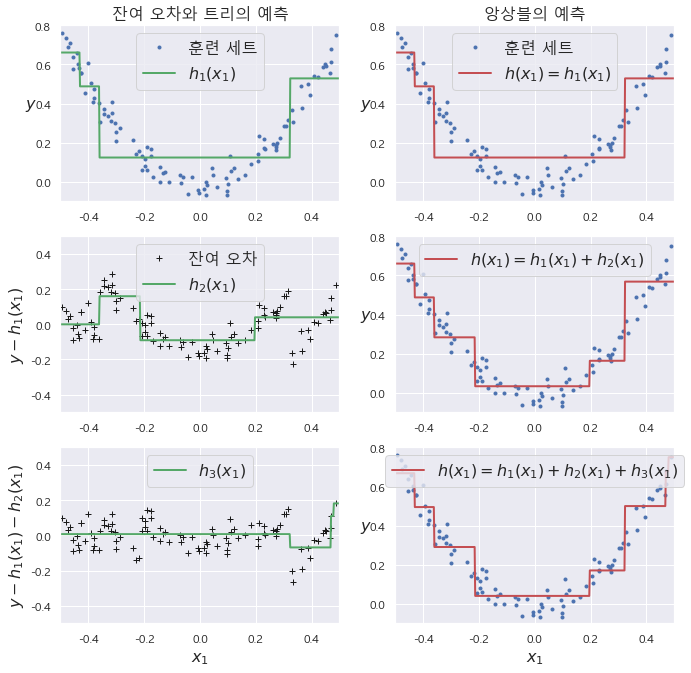

In [37]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

이번에는 Scikit-Learn의 [`GradientBoostingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)를 이용해 위의 과정과 동일하게 모델링 해보자. 아래의 결과에서 볼 수 있듯이, `DecisionTreeRegressor`를 이용해 그래디언트 부스팅을 단계별로 수행한 것과 동일한것을 알 수 있다.

`GradientBoostingRegressor`에서 `learning_rate`($\eta$) 인자는 학습 단계에서 각 모델(트리)의 반영 비율을 의미한다. 

$$
H_t(\mathbf{x}) = H_{t-1}(\mathbf{x}) + \eta h_t(\mathbf{x})
$$

- $\eta$의 값은 $0 < \eta \le 1$이며, 값이 작을 수록 학습을 위해 더 많은 모델(트리)가 필요하지만, 성능은 좋아진다.

이렇게 `learning_rate`($\eta$)를 이용하는 방법을 **축소**(shrinkage)라고 하는 규제(regularization) 방법이다.

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [44]:
print('y_pred :', gbrt.predict(X_new))

y_pred : [0.75026781]


아래의 예제는 학습시킬 모델의 개수(`n_estimator`)를 3개와 200개로 했을 때의 차이를 나타낸 것이다.

In [45]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

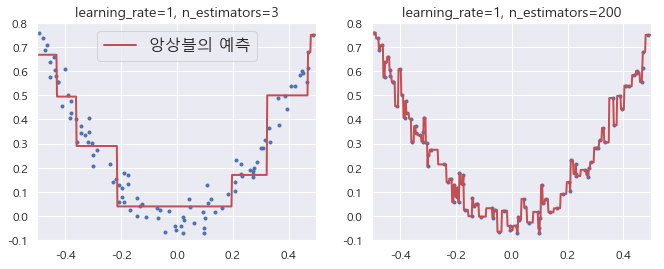

In [46]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="앙상블의 예측")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

#### 조기종료(early stopping)을 이용한 그래디언트 부스팅

그래디언트 부스팅의 학습 단계에서 학습 시킬 최적의 트리(모델)의 개수를 찾기 위해 [조기 종료(early stopping)](https://github.com/ExcelsiorCJH/Hands-On-ML/blob/master/Chap04-Training_Models/Chap04-Training_Models.ipynb)을 사용할 수 있다. 

아래의 예제는 GBRT를 학습시킨 후 `staged_predict()` 메소드를 이용해 각 모델의 예측값(`y_pred`)과 실제값(`y_val`)의 MSE를 구한 뒤 MSE가장 낮은 최적의 트리의 개수를 찾아 다시 최적의 트리 개수(`best_n_estimator`)로 그래디언트 부스팅을 학습시키는 예제이다.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# 최적의 트리 개수 찾기
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

# 최적의 트리개수로 그래디언트 부스팅 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

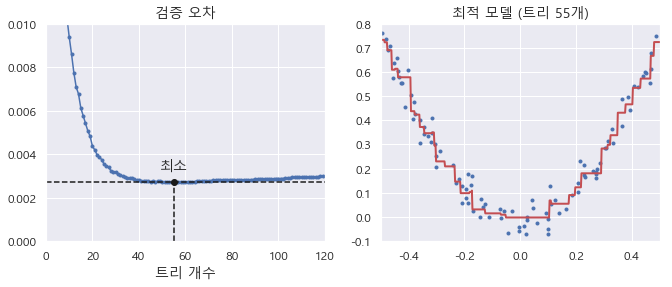

In [51]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

plt.show()

다음 예제는 학습 과정에서 최적의 트리 개수를 찾았을 때, 학습을 조기종료 하는 예제이다.

In [52]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [54]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 61
최소 검증 MSE: 0.002712853325235463


## 7.6 스태킹 (Stacking)

**스태킹**(stacking, stacked generalization의 줄임)은 '7.1 - 투표 기반 분류기'에서 처럼 'hard voting', 'soft voting' 방법이 아니라 앙상블 학습에서 각 모델의 예측값을 가지고 새로운 **메타 모델(meta learner)**을 학습시켜 최종 예측 모델을 만드는 방법을 말한다.

![](./images/stacking.png)

스태킹(stacking)의 과정은 다음과 같다.

1. 학습 데이터셋에서 샘플링을 통해 서브셋1(subset-1)을 만들고, 이 서브셋을 이용해 각 모델을 학습시킨다. 
2. 서브셋2(subset-2) 학습 시킨 모델을 이용해 각 모델의 예측값을 출력하고 예측값들을 합친다.
3. 합쳐진 예측값들을 입력 특성(input feature)로 사용하는 새로운 모델(meta learner, blender)을 학습시킨다.